In [2]:
pip install mlflow

                                              0.0/29.0 MB ? eta -:--:--
                                              0.0/29.0 MB ? eta -:--:--
                                              0.1/29.0 MB 1.3 MB/s eta 0:00:22
                                              0.1/29.0 MB 1.2 MB/s eta 0:00:24
                                              0.2/29.0 MB 1.6 MB/s eta 0:00:19
                                              0.3/29.0 MB 1.5 MB/s eta 0:00:20
                                              0.4/29.0 MB 1.4 MB/s eta 0:00:20
                                              0.6/29.0 MB 2.0 MB/s eta 0:00:14
     -                                        0.7/29.0 MB 2.2 MB/s eta 0:00:13
     -                                        0.9/29.0 MB 2.4 MB/s eta 0:00:12
     -                                        1.0/29.0 MB 2.5 MB/s eta 0:00:12
     -                                        1.2/29.0 MB 2.6 MB/s eta 0:00:11
     -                                        1.4/29.0 MB 2.8 MB/s


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\Startklar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Startklar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Accuracy: 0.8557
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      3377
           1       0.97      0.76      0.85      4022

    accuracy                           0.86      7399
   macro avg       0.87      0.87      0.86      7399
weighted avg       0.88      0.86      0.86      7399



2025/05/13 13:44:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔ Run logged with accuracy: 0.8557


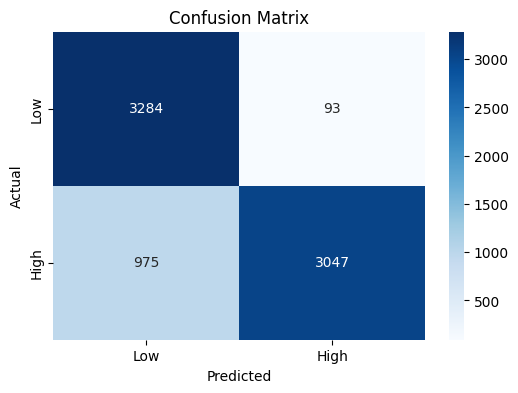

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif  # Feature selection
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix

# 📁 Create artifact directory if it doesn't exist
os.makedirs("artifacts", exist_ok=True)

# 📦 Load your churn data
df = pd.read_csv("C:\\Users\\Startklar\\Downloads\\churn project\\churn project\\churn.csv")  # Update path if needed
X = df.drop("churn_risk_score", axis=1)   # Features
y = df["churn_risk_score"]                # Target

# Ensure that categorical variables are encoded correctly with sparse matrix
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X)

# ✂ Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 🚀 Standardize features to improve SVM performance using sparse matrix
scaler = StandardScaler(with_mean=False)  # Don't center data (necessary for sparse matrices)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🌟 Feature Selection: Select K Best Features (using ANOVA F-value)
# Choose top 50 features for simplicity
selector = SelectKBest(score_func=f_classif, k=50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# 🔧 Dimensionality Reduction with PCA (50 components as an example)
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_selected.toarray())  # Convert sparse to dense for PCA
X_test_pca = pca.transform(X_test_selected.toarray())

# 📡 Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

# 📡 Start MLflow experiment tracking
with mlflow.start_run():

    # 🔧 Parameters for SVM model
    kernel = 'linear'  # Use linear kernel for simplicity
    C = 1.0  # Regularization parameter
    model = SVC(kernel=kernel, C=C, random_state=42)
    
    # 🧠 Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # 🔍 Predict & evaluate
    y_pred = model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # 📊 Log parameters
    mlflow.log_param("kernel", kernel)
    mlflow.log_param("C", C)

    # 📈 Log metrics
    mlflow.log_metric("accuracy", acc)

    # 📁 Log artifact: Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm_artifact_path = "artifacts/confusion_matrix.png"
    plt.savefig(cm_artifact_path)
    mlflow.log_artifact(cm_artifact_path)

    # 💾 Log the trained model
    mlflow.sklearn.log_model(model, "svm_model")

    print(f"✔ Run logged with accuracy: {acc:.4f}")
